2018 Fall  
Final Project  
# **Quick-Draw Pictures Recognition with CNN**

---
2조  
182STG24 박수경  
182STG18 이하경  
182STG27 임지연

---
과목명 | 금융공학  
교수명 | 안재윤 교수님  
제출일 | 2018년 12월 17일  

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import keras

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


## Data Exploration

In [0]:
classes = ['guitar', 'fish', 'laptop', 'pencil', 'scissors',
           'sheep', 'soccer_ball', 'teddy-bear', 'The_Eiffel_Tower', 'The_Mona_Lisa']

# 10가지 CLASS만 사용한다

In [0]:
!mkdir dataset # 디렉토리 경로 생성

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  
  for c in classes:
    class_url = c.replace('_', '%20')
    path = base + class_url + '.npy'
    
    print(path)
    urllib.request.urlretrieve(path, 'dataset/' + c + '.npy')

In [0]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/guitar.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pencil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/scissors.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/soccer%20ball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/teddy-bear.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Mona%20Lisa.npy


In [0]:
def load_data(root, max_items_per_class = 10000):
  all_files = glob.glob(os.path.join(root, '*.npy'))
  
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []
  
  # 파일을 하나씩 로드
  for idx, file in enumerate(all_files):
    data = np.load(file)
    data = data[0:max_items_per_class, :]
    labels = np.full(data.shape[0], idx)
    
    x = np.concatenate((x, data), axis = 0)
    y = np.append(y, labels)
    
    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)
    
  data = None
  labels = None
  
  # 순서를 무작위로 섞는다
  x, y = shuffle(x, y, random_state = 100)

  # train(80%), test(20%) 
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                      random_state = 100)
  
  return x_train, x_test, y_train, y_test, class_names

In [0]:
x_train, x_test, y_train, y_test, class_names = load_data('dataset')

In [0]:
n_classes = len(class_names) # 10 classes

In [0]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, n_classes)

(80000, 784) (80000,) (20000, 784) (20000,) 10


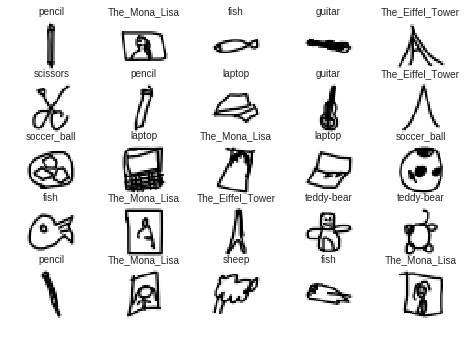

In [0]:
randomid = np.random.randint(0, len(x_train), size = 25)

fig = plt.figure()

for i in range(25):
  plt.subplot(5, 5, i +1)
  plt.axis('off')
  plt.imshow(x_train[randomid[i]].reshape(28, 28))
  plt.title(class_names[int(y_train[randomid[i]].item())], fontsize = 10)
  
plt.show()

In [0]:
# CNN을 위해 4차원으로 Reshape
trainX = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
testX = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# Color을 (0-1) 사이 값으로 반환
trainX /= 255.0
testX /= 255.0

# One-Hot Code 형식으로 변환
trainY = keras.utils.to_categorical(y_train, n_classes)
testY = keras.utils.to_categorical(y_test, n_classes)

In [0]:
print(trainY.shape)
trainY

(80000, 10)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Modeling

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [0]:
# Filters' Width, Height
FW1 = 5
FW2 = 5

# Number of Filters
FN1 = 64
FN2 = 64

n_hidden = 256     # Affine Layer의 Node 수
batch_size = 128
epochs = 10

In [0]:
model = Sequential()

Convolution Layers

In [0]:
# Convolution Layer 1
model.add(Conv2D(FN1, kernel_size = (FW1, FW1), padding = 'same', 
                 activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution Layer 2
model.add(Conv2D(FN2, kernel_size = (FW2, FW2), padding = 'same',
                 activation = 'relu', input_shape = (14, 14, FN1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

Affine (Dense) Layers

In [0]:
model.add(Flatten())

# Affine Layer 1
model.add(Dense(n_hidden, activation = 'relu'))

# Affine Layer 2 (Output Layer)
model.add(Dense(n_classes, activation = 'softmax'))

In [0]:
optimizer = tf.train.AdamOptimizer() # learning_rate = 0.001 (default)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer,
              metrics = ['accuracy'])

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total para

In [0]:
my_learning = model.fit(trainX, trainY, 
                        batch_size = batch_size, 
                        epochs = epochs,
                        validation_data = (testX, testY))

# history 저장

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 12s 147us/step - loss: 0.3552 - acc: 0.8952 - val_loss: 0.2121 - val_acc: 0.9405
Epoch 2/10
80000/80000 [==============================] - 11s 142us/step - loss: 0.1789 - acc: 0.9496 - val_loss: 0.1760 - val_acc: 0.9481
Epoch 3/10
80000/80000 [==============================] - 11s 142us/step - loss: 0.1345 - acc: 0.9611 - val_loss: 0.1534 - val_acc: 0.9569
Epoch 4/10
80000/80000 [==============================] - 11s 142us/step - loss: 0.1035 - acc: 0.9694 - val_loss: 0.1465 - val_acc: 0.9587
Epoch 5/10
80000/80000 [==============================] - 11s 142us/step - loss: 0.0751 - acc: 0.9772 - val_loss: 0.1626 - val_acc: 0.9569
Epoch 6/10
80000/80000 [==============================] - 11s 143us/step - loss: 0.0533 - acc: 0.9832 - val_loss: 0.1901 - val_acc: 0.9552
Epoch 7/10
80000/80000 [==============================] - 11s 143us/step - loss: 0.0364 - acc: 0.9885 - val_loss: 0.

## Evaluation

In [0]:
train_score = model.evaluate(trainX, trainY, verbose = 0)
test_score = model.evaluate(testX, testY, verbose = 0)

print('Train Accuracy: {}%'.format(train_score[1] * 100))
print('Test Accuracy: {}%'.format(test_score[1] * 100))

Train Accuracy: 99.575%
Test Accuracy: 95.54%


In [0]:
train_loss = my_learning.history['loss']
train_accuracy = my_learning.history['acc']
test_loss = my_learning.history['val_loss']
test_accuracy = my_learning.history['val_acc']

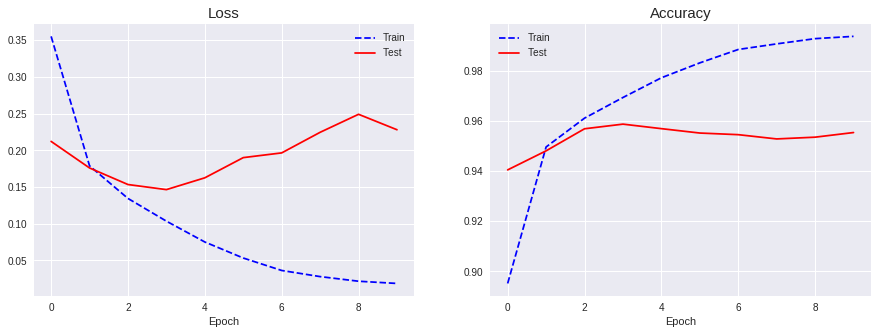

In [0]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, '--b', label = 'Train')
plt.plot(test_loss, '-r', label = 'Test')
plt.xlabel('Epoch')
plt.title('Loss', fontsize = 15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, '--b', label = 'Train')
plt.plot(test_accuracy, '-r', label = 'Test')
plt.xlabel('Epoch')
plt.title('Accuracy', fontsize = 15)
plt.legend()

plt.show()

## Prediction

In [0]:
for i in range(10):
  print("{} = {}".format(i, class_names[i]))

0 = pencil
1 = fish
2 = teddy-bear
3 = The_Eiffel_Tower
4 = scissors
5 = guitar
6 = The_Mona_Lisa
7 = sheep
8 = laptop
9 = soccer_ball


In [0]:
sampleID = np.random.randint(0, len(testX), 10)
sampleX = np.array([testX[i] for i in sampleID])
sampleY = np.array([testY[i] for i in sampleID])

predicted = model.predict_classes(sampleX, verbose = 0) 

targets = np.argmax(sampleY, axis = 1)                  
predictions = predicted                                 

print(targets)
print(predictions)

[3 1 2 7 5 9 7 3 6 4]
[3 1 2 7 5 9 7 3 6 4]


In [0]:
model.predict_classes(sampleX)

array([3, 1, 2, 7, 5, 9, 7, 3, 6, 4])

In [0]:
predicted_prob = model.predict(sampleX, verbose = 0)

print("Sample 2: ", np.round(predicted_prob[1], 3))
print("Sample 7: ", np.round(predicted_prob[6], 3))

Sample 2:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 7:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


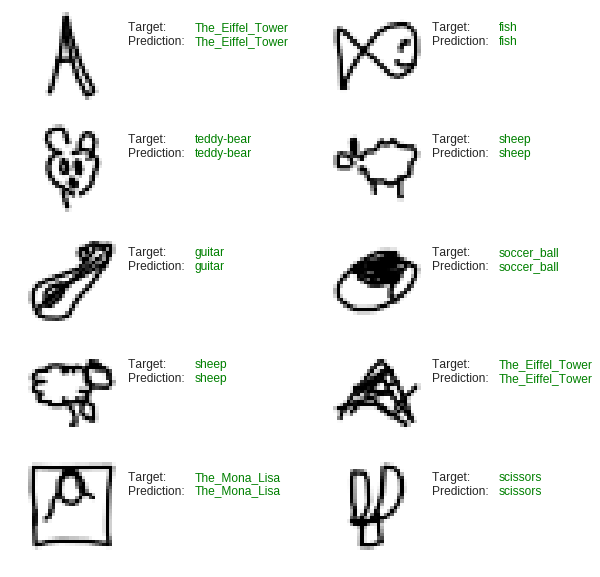

In [0]:
fig = plt.figure(figsize = (10, 10))

for i in range(len(sampleX)):
  target = targets[i]
  prediction = predictions[i]
  
  plt.subplot(5, 2, i +1)
  plt.axis('off')
  color = 'green' if target == prediction else 'red'
  plt.text(30, 10, "Target: \nPrediction:", fontsize = 12)
  plt.text(50, 10, "{0}\n{1}".format(class_names[target], class_names[prediction]),
           fontsize = 12, color = color)
  plt.imshow(sampleX[i].reshape(28, 28))

plt.show()

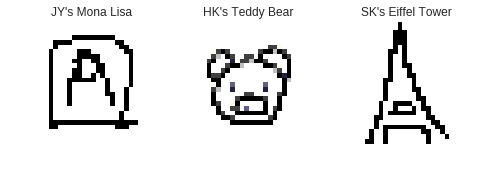

In [0]:
from PIL import Image

im1 = Image.open('monalisa.bmp')
im2 = Image.open('bear.bmp')
im3 = Image.open('eiffel.bmp')

im_title = ["JY's Mona Lisa", "HK's Teddy Bear", "SK's Eiffel Tower"]

for i, im in enumerate([im1, im2, im3]):
  plt.subplot(1, 3, i +1)
  plt.imshow(im)
  plt.axis('off')
  plt.title(im_title[i])

plt.show()

In [0]:
ims = np.array([np.array(im1), 
                np.array(im2), 
                np.array(im3)])
print(ims.shape)

ims = ims.reshape(3, 28, 28, 1)
ims = ims / 255.0
ims = 1- ims

labels = np.array([np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),  # 6: Mona Lisa
                   np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),  # 2: Teddy Bear
                   np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])]) # 3: Eiffel Tower
print(labels.shape)

(3, 28, 28)
(3, 10)


In [0]:
predict_class = model.predict_classes(ims, verbose = 0)
predict_prob = model.predict(ims, verbose = 0)

In [0]:
print(predict_class)
print(np.round(predict_prob, 3))

[6 2 3]
[[0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.718 0.    0.    0.003 0.    0.149 0.    0.13 ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]]
